<a href="https://colab.research.google.com/github/poppitypopper/BinaryPrediction/blob/main/QCAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **QCAR Project, First Semester 2025-26**
---
#### *Mid-term, October, 2025*

Nishit Singh, Aditya Tiwari, Chaitanya Jaiswal, Ritwik Rai

***Analysis of a CNC - Vibration dataset from the shop-floor of the Brownfield Bosch Plant collected in 6 month intervals from Oct 2018 - Aug 2022.***

---

###*Analysing and Cataloguing Data*

There is data present for three different machines `[M01, M02, M03]` for fifteen different operations `[OP01, OP02, OP03...OP15]` and labels `good` and `bad` per process. The raw data is stored in `.h5` files and requires the `numpy` package to be parsed.

[Catalogued data available here](https://github.com/boschresearch/CNC_Machining/tree/main/data)

---

###*Plotting*

The following code snippet is to load separate files and plot the data individually.

[Dependencies such as `utils.py` available here](https://github.com/boschresearch/CNC_Machining/tree/main/utils)

In [ ]:
import os
from pathlib import Path
from utils import data_loader_utils
import itertools

machines = ["M01","M02","M03"]
process_names = ["OP00","OP01","OP02","OP03","OP04","OP05","OP06","OP07","OP08","OP09","OP10","OP11","OP12","OP13","OP14"]
labels = ["good","bad"]
path_to_dataset = Path("./data/").absolute()

X_data = []
y_data = []

for process_name, machine, label in itertools.product(process_names, machines, labels):
    data_path = os.path.join(path_to_dataset, machine, process_name, label)
    data_list, data_label = data_loader_utils.load_tool_research_data(data_path, label=label)
    #concatenating
    X_data.extend(data_list)
    y_data.extend(data_label)

file = Path("./data/M01/OP01/bad/M01_Aug_2019_OP01_000.h5").absolute()
sample = data_loader_utils.datafile_read(file)

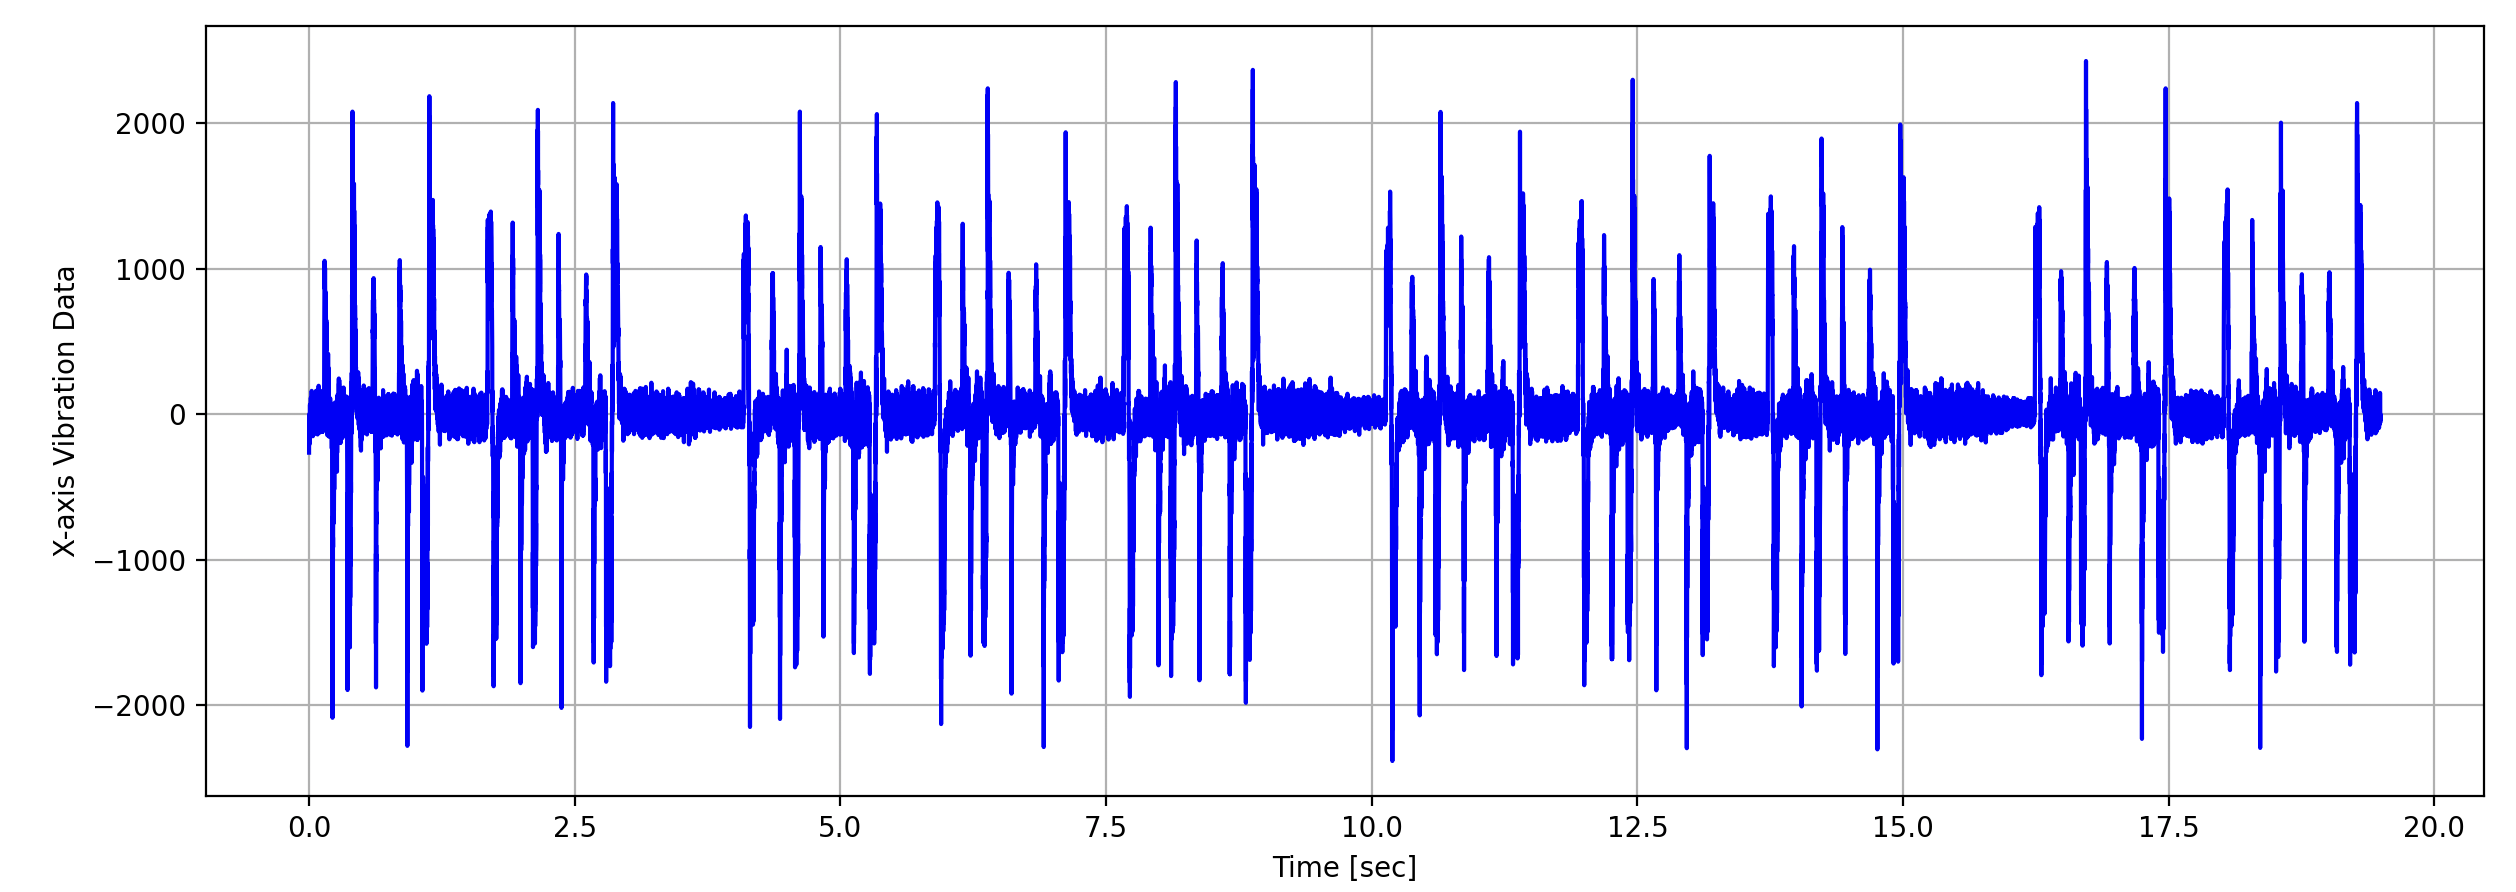

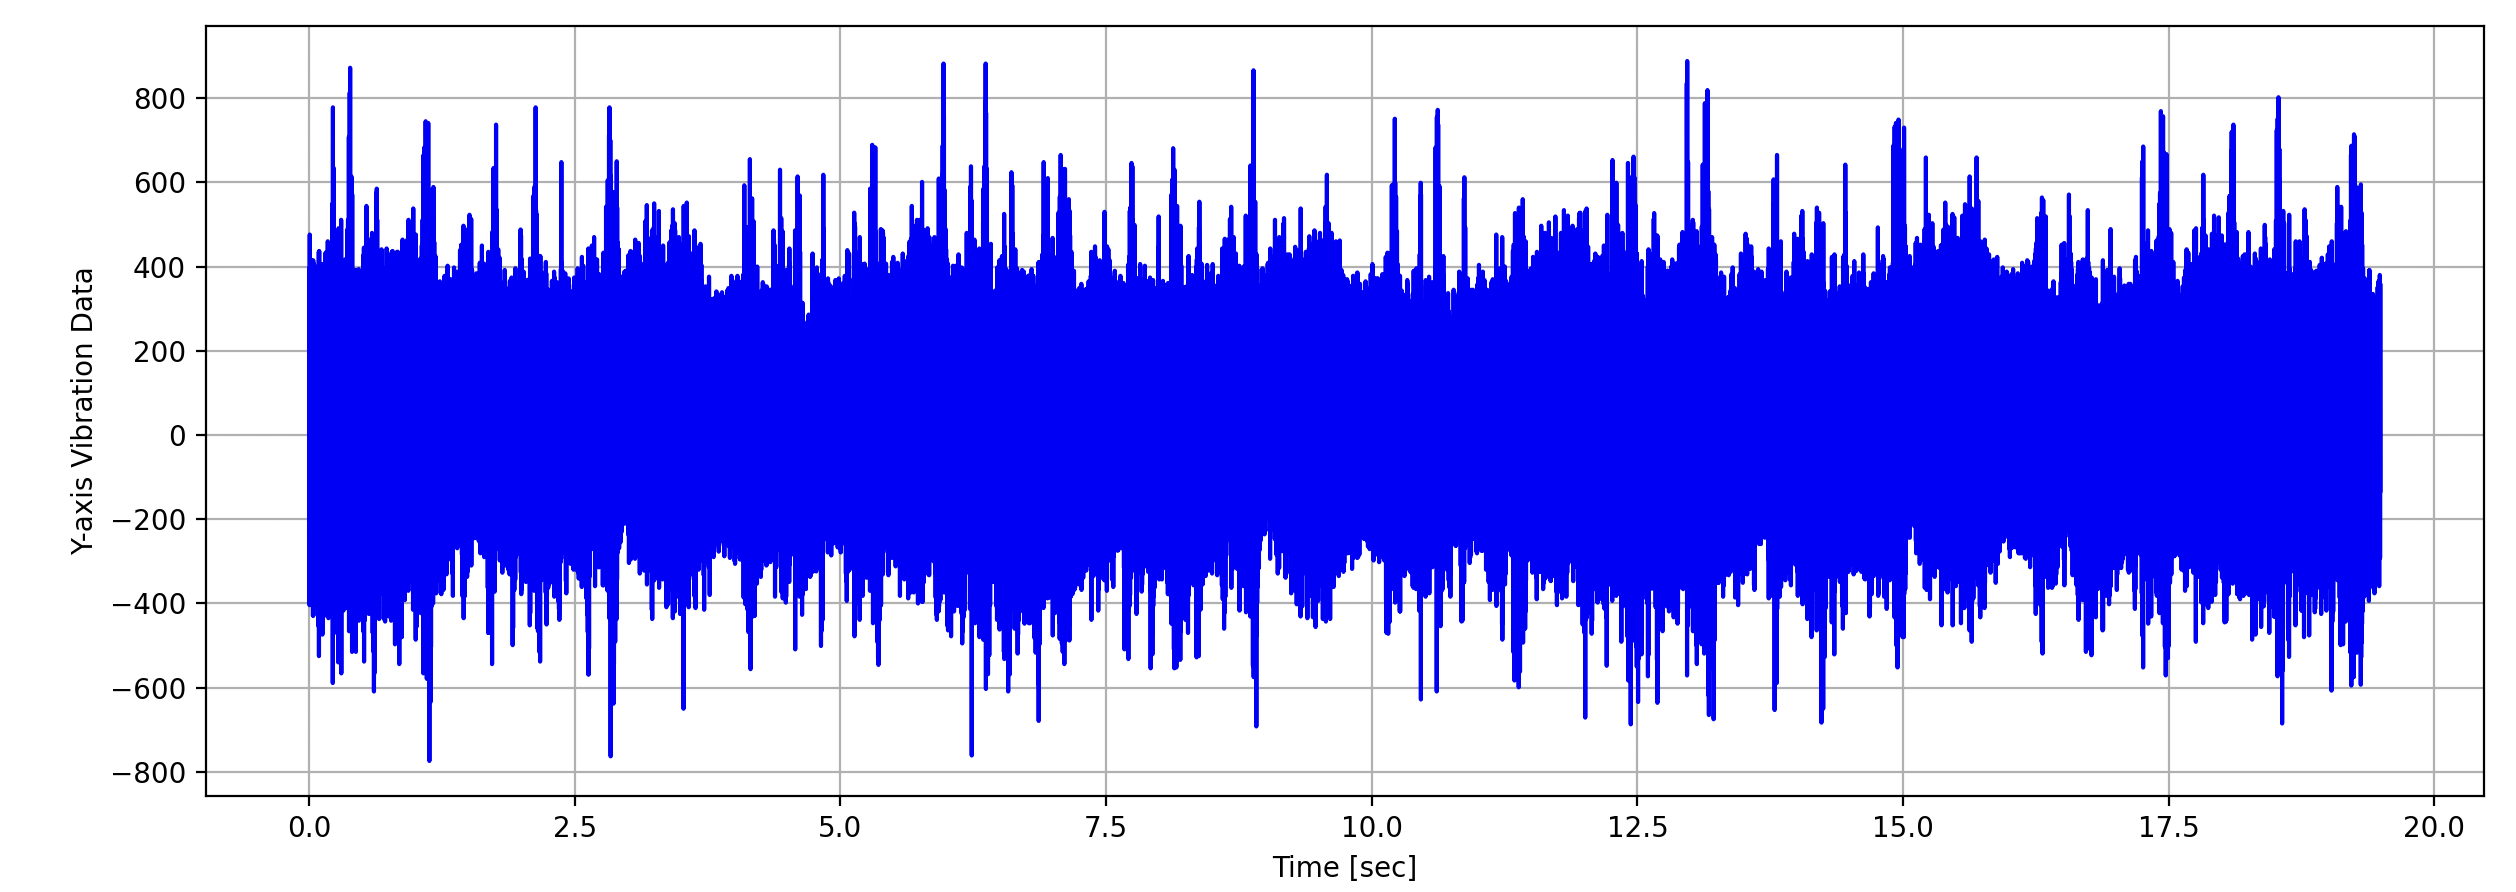

---


###*Extracting dataset features (variance, mean)*

Calculating variances per process $ V_{machine}^{process} $ (For machine M01 and process OP12, for example, the variance for the process will be $ V_{M01}^{OP12} $ ) is handled by the following code.

---

Calculating average variance per machine per label (good/bad) $ V_{machine}^{label} $ (For machine M01, for example, the variance for all good processes will be $ V_{M01}^{good} $ ) is handled by the following code.




*Note* : Since $ V_{machine}^{label} = \frac{1}{(N)} \sum_{i=1}^{N} V_{machine}^{OP(N)} $ , the code is just basic summation.

---

In [ ]:
import os
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score


In [ ]:
def extract_features(signal_x, signal_y, signal_z):
    return {
        "var_x": np.var(signal_x),
        "var_y": np.var(signal_y),
        "var_z": np.var(signal_z),
        "mean_x": np.mean(signal_x),
        "mean_y": np.mean(signal_y),
        "mean_z": np.mean(signal_z),
    }

*Note* : The variance is one statistic that we've elaborated upon, the regression model finally also utilises the mean as another statistic.

Below are plots for the a feature ( `mean` ) for all three axes of M01 for all processes, color coded (green = `good`, red = `bad`)

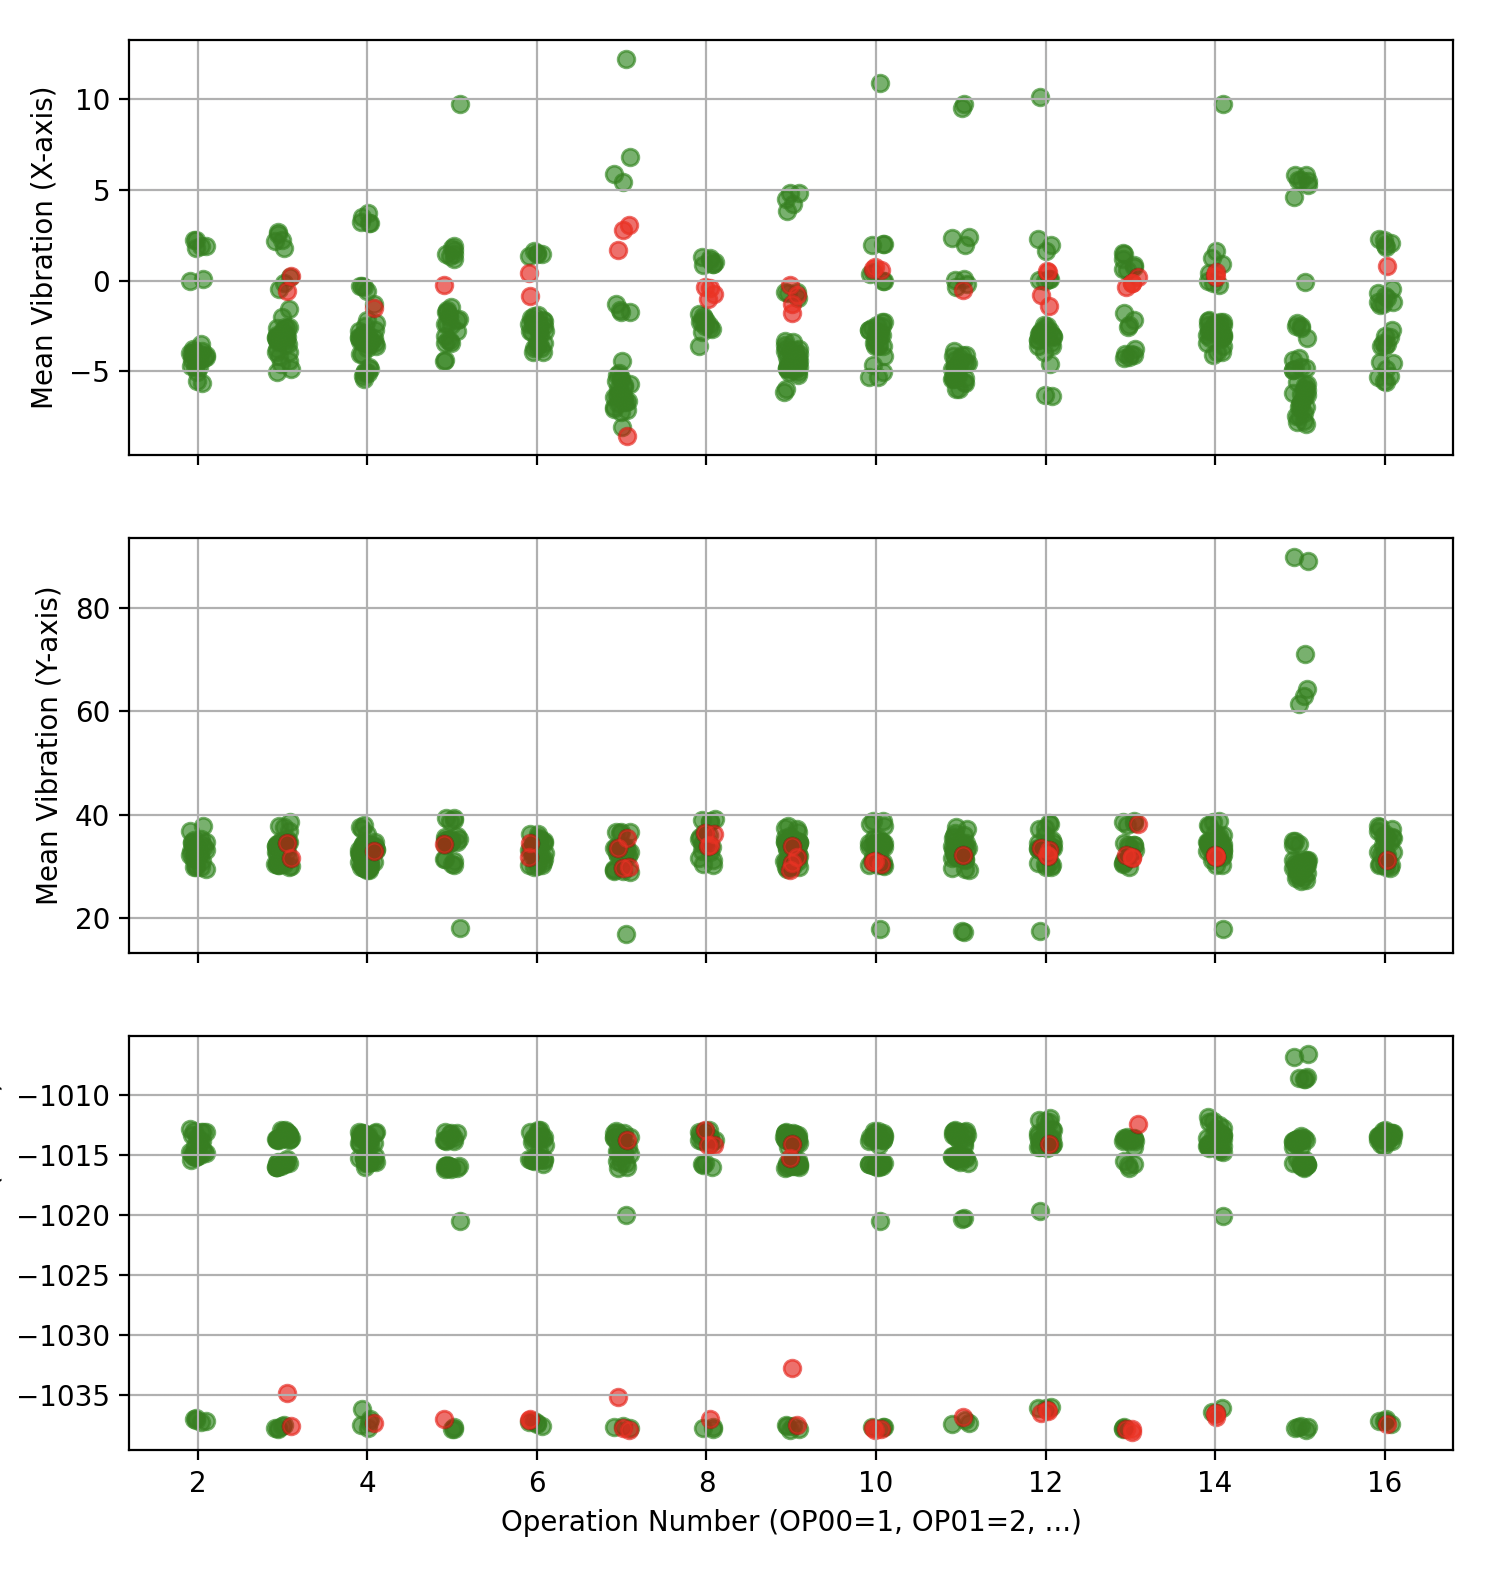

---

###*Regression model*

Now that we have the average variances for each machine for a good and bad process, we can run a simple linear regression model to quantify and predict good processes from bad processes ahead of completion time.

---

Visually, plotting the variances of each process for a single machine and a label (say all `good` processes for M01), and then doing the same for the other label (`bad` processes for M01), a regression model will find a straight line which divides processes into `good` or `bad` and will be able to predict if a process is running smoothly by placing data in the same embedding space and finding out if it is "above" or "below" the regression line.

In [ ]:

def load_machine_data(base_path, machine="M01"):
    X, y, ops = [], [], []
    machine_path = os.path.join(base_path, machine)

    for op in sorted(os.listdir(machine_path)):  # OP01, OP02, ...
        op_path = os.path.join(machine_path, op)
        if not os.path.isdir(op_path):
            continue

        for label in ["good", "bad"]:
            label_path = os.path.join(op_path, label)
            if not os.path.exists(label_path):
                continue

            for file in os.listdir(label_path):
                if not file.endswith(".h5"):
                    continue

                file_path = os.path.join(label_path, file)
                try:
                    with h5py.File(file_path, "r") as f:
                        data = f["vibration"][:]  # shape (n_samples, 3)
                        features = extract_features(data)

                        X.append(list(features.values()))
                        y.append(1 if label == "good" else 0)
                        ops.append(op)
                except Exception as e:
                    print(f"Error reading {file_path}: {e}")

    return np.array(X), np.array(y), np.array(ops)



In [ ]:

def train_model(base_path, machine="M01"):
    print(f"Loading data for {machine}...")
    X, y, ops = load_machine_data(base_path, machine)
    print(f"Loaded {X.shape[0]} samples from {len(set(ops))} operations.")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC: {roc_auc_score(y_test, y_prob):.3f}")

    return model


In [ ]:

def predict_file(model, file_path):
    with h5py.File(file_path, "r") as f:
        data = f["vibration"][:]
        features = extract_features(data)
        X_new = np.array(list(features.values())).reshape(1, -1)
        pred = model.predict(X_new)[0]
        return "good" if pred == 1 else "bad"

In [ ]:

if __name__ == "__main__":
    base_path = "CNC_Machining/data"

    model = train_model(base_path, machine="M01")

    test_file = "CNC_Machining/data/M01/OP01/good/sample_0001.h5"
    result = predict_file(model, test_file)
    print(f"\nPrediction for {test_file}: {result}")
